# Knowledge Distillation for Convolutional Networks
Following: https://medium.com/analytics-vidhya/knowledge-distillation-for-convolutional-networks-e73682c611e8

In [1]:
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
from torch import nn, optim

In [2]:
# Ref: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='/mnt/d/PublicData/CIFAR10', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='/mnt/d/PublicData/CIFAR10', train=False,
                                       download=True, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

len_trainset = len(trainset)
len_valset = len(valset)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
device_id = torch.cuda.device_count()
print(device_id)

# device = torch.device("cuda:0,1,2,3" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# https://stackoverflow.com/questions/54216920/how-to-use-multiple-gpus-in-pytorch

8


In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([128, 3, 32, 32])
torch.Size([128])


In [5]:
resnet = models.resnet50(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False
    
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)
resnet = resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters())

In [6]:
def train_and_evaluate(model, trainloader, valloader, criterion, optimizer, len_trainset, len_valset, num_epochs=25):
    model.train()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history_train = torch.empty(0,2)
    history_validate = torch.empty(0,2)
#     print(history)
    for epoch in range(num_epochs):
        model.train()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in trainloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward() 
            optimizer.step()  
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len_trainset
        epoch_acc = running_corrects.double() / len_trainset
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss,epoch_acc)) 
        history_train = torch.cat([history_train,torch.FloatTensor([[epoch_acc, epoch_loss]])],dim=0)
        model.eval()
        running_loss_val = 0.0 
        running_corrects_val = 0
        for inputs, labels in valloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs) 
            loss = criterion(outputs,labels)
            _, preds = torch.max(outputs, 1)
            running_loss_val += loss.item() * inputs.size(0)
            running_corrects_val += torch.sum(preds == labels.data)

        epoch_loss_val = running_loss_val / len_valset
        epoch_acc_val = running_corrects_val.double() / len_valset

        if epoch_acc_val > best_acc:
            best_acc = epoch_acc_val
            best_model_wts = copy.deepcopy(model.state_dict())

        print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_val, epoch_acc_val))
        print('Best val Acc: {:4f}'.format(best_acc))
        history_validate = torch.cat([history_validate,torch.FloatTensor([[epoch_acc_val,epoch_loss_val]])],dim=0)
#         print(history)
        model.load_state_dict(best_model_wts)
    return model, history_train, history_validate

In [7]:
resnet_teacher, history_train_teacher, history_validate_teacher = train_and_evaluate(resnet,trainloader, valloader,criterion,optimizer, len_trainset,len_valset,50)

Epoch 0/49
----------
Train Loss: 1.6479 Acc: 0.4346
Val Loss: 1.5294 Acc: 0.4815
Best val Acc: 0.481500
Epoch 1/49
----------
Train Loss: 1.4560 Acc: 0.5048
Val Loss: 1.4313 Acc: 0.5118
Best val Acc: 0.511800
Epoch 2/49
----------
Train Loss: 1.4025 Acc: 0.5203
Val Loss: 1.4053 Acc: 0.5264
Best val Acc: 0.526400
Epoch 3/49
----------
Train Loss: 1.3702 Acc: 0.5329
Val Loss: 1.3906 Acc: 0.5291
Best val Acc: 0.529100
Epoch 4/49
----------
Train Loss: 1.3491 Acc: 0.5384
Val Loss: 1.4076 Acc: 0.5225
Best val Acc: 0.529100
Epoch 5/49
----------
Train Loss: 1.3497 Acc: 0.5377
Val Loss: 1.3913 Acc: 0.5277
Best val Acc: 0.529100
Epoch 6/49
----------
Train Loss: 1.3452 Acc: 0.5387
Val Loss: 1.4246 Acc: 0.5258
Best val Acc: 0.529100
Epoch 7/49
----------
Train Loss: 1.3450 Acc: 0.5376
Val Loss: 1.3967 Acc: 0.5240
Best val Acc: 0.529100
Epoch 8/49
----------
Train Loss: 1.3514 Acc: 0.5408
Val Loss: 1.3787 Acc: 0.5316
Best val Acc: 0.531600
Epoch 9/49
----------
Train Loss: 1.3231 Acc: 0.5468
Va

In [8]:
def evalue_chart_acc_and_loss(history_acc_loss, chart_name):
    num_epochs = len(history_acc_loss)
    history_chart_acc = [h.cpu().numpy()[0] for h in history_acc_loss]
    history_chart_losses = [h.cpu().numpy()[1] for h in history_acc_loss]
    
    plt.title("{} Accuracy vs. Number of Epochs".format(chart_name))
    plt.xlabel("{} Epochs".format(chart_name))
    plt.ylabel("{} Accuracy".format(chart_name))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.plot(range(1,num_epochs+1),history_chart_acc,label="{} - Accurancy".format(chart_name),color='blue')
    plt.legend()
    plt.show()

    plt.title("{} Loss vs. Number of Epochs".format(chart_name))
    plt.xlabel("{} Epochs".format(chart_name))
    plt.ylabel("{} Loss".format(chart_name))
    plt.xticks(np.arange(1, num_epochs+1, 1.0))
    plt.plot(range(1,num_epochs+1),history_chart_losses,label="{} - Loss".format(chart_name), color='orange')
    plt.legend()
    plt.show()

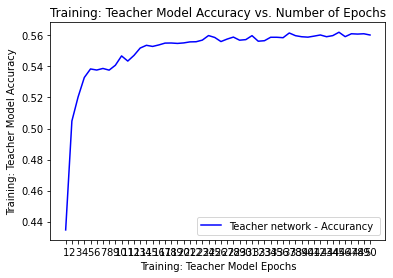

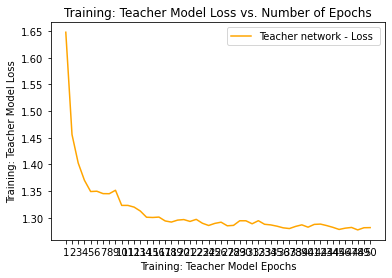

In [9]:
evalue_chart_acc_and_loss(history_train_teacher, "Training: Teacher Model")

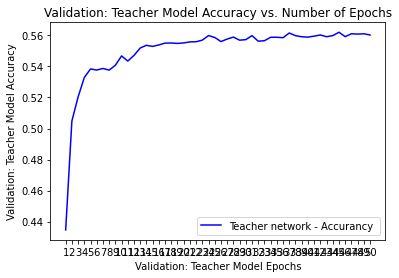

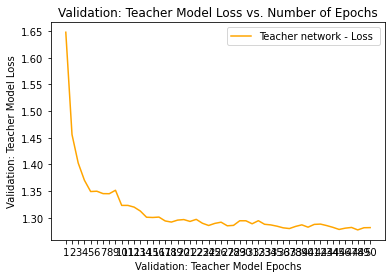

In [10]:
evalue_chart_acc_and_loss(history_train_teacher, "Validation: Teacher Model")

In [11]:
class Net(nn.Module):
    """
    This will be your student network that will learn from the 
    teacher network in our case resnet50.
    """
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = (3,3), stride = (1,1), 
            padding = (1,1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size = (3,3), stride = (1,1), 
            padding = (1,1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, 
            dilation=1, ceil_mode=False)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size = (3,3), stride = (1,1), 
            padding = (1,1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size = (3,3), stride = (1,1), 
            padding = (1,1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, 
            dilation=1, ceil_mode=False)
        )
        self.pool1 = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc1 = nn.Linear(128, 32)
        self.fc2 = nn.Linear(32, 10)
        self.dropout_rate = 0.5
   
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.pool1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
net = Net().to(device)

In [12]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
out = net(images.cuda())
print(out.shape)

torch.Size([128, 10])


In [13]:
def loss_kd(outputs, labels, teacher_outputs, temparature, alpha):
    KD_loss = nn.KLDivLoss()(F.log_softmax(outputs/temparature, dim=1),F.softmax(teacher_outputs/temparature,dim=1)) * (alpha * temparature * temparature) + F.cross_entropy(outputs, labels) * (1. - alpha)
    return KD_loss

def get_outputs(model, dataloader):
    '''
    Used to get the output of the teacher network
    '''
    outputs = []
    for inputs, labels in dataloader:
        inputs_batch, labels_batch = inputs.cuda(), labels.cuda()
        output_batch = model(inputs_batch).data.cpu().numpy()
        outputs.append(output_batch)
    return outputs

In [14]:
def train_kd(model,teacher_out, optimizer, loss_kd, dataloader, temparature, alpha):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    history = torch.empty(0,2)
    for i,(images, labels) in enumerate(dataloader):
        inputs = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs_teacher = torch.from_numpy(teacher_out[i]).to(device)
        loss = loss_kd(outputs,labels,outputs_teacher,temparature, alpha)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(trainset)
    epoch_acc = running_corrects.double() / len(trainset)
    print('train_kd - Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    history = torch.cat([history,torch.FloatTensor([[epoch_acc, epoch_loss]])],dim=0)
    return history

def eval_kd(model,teacher_out, optimizer, loss_kd, dataloader, temparature, alpha):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    for i,(images, labels) in enumerate(dataloader):
        inputs = images.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        outputs_teacher = torch.from_numpy(teacher_out[i]).cuda()
        loss = loss_kd(outputs,labels,outputs_teacher,temparature, 
                     alpha)
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(valset)
    epoch_acc = running_corrects.double() / len(valset)
    print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    return epoch_acc, epoch_loss

def train_and_evaluate_kd(model, teacher_model, optimizer, loss_kd, trainloader, valloader, temparature, alpha, num_epochs=25):
    teacher_model.eval()
    best_model_wts = copy.deepcopy(model.state_dict())
    outputs_teacher_train = get_outputs(teacher_model, trainloader)
    outputs_teacher_val = get_outputs(teacher_model, valloader)
    
    history_evaluation = torch.empty(0,2)
    
    print("Teacher’s outputs are computed now starting the training process-")
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Training the student with the soft labes as the outputs from the teacher and using the loss_kd function

        train_kd_history = train_kd(model, outputs_teacher_train, optim.Adam(net.parameters()),loss_kd,trainloader, temparature, alpha)
#         evalue_chart_acc_and_loss(train_kd_history, "Training Knowledge Distillation")

        # Evaluating the student network
        epoch_acc_val, epoch_loss_val = eval_kd(model, outputs_teacher_val, optim.Adam(net.parameters()), loss_kd, valloader, temparature, alpha)
        history_evaluation = torch.cat([history_evaluation,torch.FloatTensor([[epoch_acc_val, epoch_loss_val]])],dim=0)
        
        if epoch_acc_val > best_acc:
            best_acc = epoch_acc_val
            best_model_wts = copy.deepcopy(model.state_dict())
            print('Best val Acc: {:4f}'.format(best_acc))
            model.load_state_dict(best_model_wts)
    return model, history_evaluation

In [15]:
student_model, student_hist_eval =train_and_evaluate_kd(net,resnet_teacher, optim.Adam(net.parameters()),loss_kd,trainloader,valloader,1,0.5,50)

Teacher’s outputs are computed now starting the training process-
Epoch 0/49
----------


/home/eeaiserver/pt-gpu/lib/python3.8/site-packages/torch/nn/functional.py:2607: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


train_kd - Train Loss: 0.9883 Acc: 0.3134
Val Loss: 0.8352 Acc: 0.4158
Best val Acc: 0.415800
Epoch 1/49
----------
train_kd - Train Loss: 0.8347 Acc: 0.4695
Val Loss: 0.7202 Acc: 0.5013
Best val Acc: 0.501300
Epoch 2/49
----------
train_kd - Train Loss: 0.7548 Acc: 0.5491
Val Loss: 0.6657 Acc: 0.5637
Best val Acc: 0.563700
Epoch 3/49
----------
train_kd - Train Loss: 0.7045 Acc: 0.5964
Val Loss: 0.5849 Acc: 0.6245
Best val Acc: 0.624500
Epoch 4/49
----------
train_kd - Train Loss: 0.6617 Acc: 0.6372
Val Loss: 0.5621 Acc: 0.6431
Best val Acc: 0.643100
Epoch 5/49
----------
train_kd - Train Loss: 0.6333 Acc: 0.6595
Val Loss: 0.5376 Acc: 0.6692
Best val Acc: 0.669200
Epoch 6/49
----------
train_kd - Train Loss: 0.6065 Acc: 0.6840
Val Loss: 0.5370 Acc: 0.6661
Epoch 7/49
----------
train_kd - Train Loss: 0.5853 Acc: 0.7021
Val Loss: 0.4751 Acc: 0.7189
Best val Acc: 0.718900
Epoch 8/49
----------
train_kd - Train Loss: 0.5667 Acc: 0.7218
Val Loss: 0.4702 Acc: 0.7171
Epoch 9/49
----------
tr

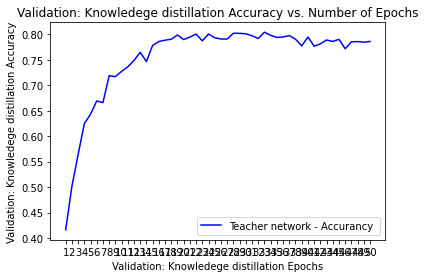

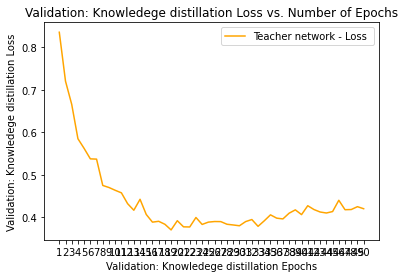

In [16]:
evalue_chart_acc_and_loss(student_hist_eval, "Validation: Knowledege distillation")